# Stock prediction using LSTM

Ref:

https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
https://github.com/mwitiderrick/stockprice/blob/master/TATA%20.ipynb


# Objective


Stock price movement has a considerable random component in it. It is difficult to predict the stock price as a function of price history. Many people have attempted to predict the stock price using different deep learning models but couldn't achieve considerable accuracy. In general the model are able to predict the trend better but not the price in the future.

With this limitation in mind I am trying to create a trading model which learns predictable price movement patterns and gives out BUY and SELL recommendations for a short term trade like 15 days. The idea is not maximize profit but to reduce on false positives. I.e., when the model suggests to BUY the chances of loosing money is minimal.

One could approach this problem as a classification problem where the model predicts BUY/SELL/HOLD labels. But here I am approaching it as a regression problem where the model predicts the max price in the future n(15) days and based on max value the program decides to BUY or SELL.

Here I am using LSTM model to predict stock trade recommendation.

# Installs, Imports & Hyper parameters

## Mount google drive

In [0]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

GPATH = "/content/gdrive/My Drive/data/stock-analysis-LSTM/"
if not os.path.exists(GPATH):
    os.makedirs(GPATH)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

#PATH
WEIGHT_FILE=GPATH+"LSTM_weight-input_close_volume-output_nthDay.h5"
#os.remove(WEIGHT_FILE)

#Hyper Parameters

##Stock Ticker
STOCK_TICKER = "ASIANPAINT.NS"

##Compare predictions of stock price starting from this year.
VALIDATE_FROM_YEAR = 2018

##Train Data starting from year
TRAIN_FROM_YEAR = 2014

##Number of history data LSTM uses to predict the future
HISTORY_LEN = 90
##Number of max trading days, as a safety measure. No matter what trade possition is closed after these many days.
MAX_TRADING_DAYS = 15

## Trading BUY/SELL threshold
UPPER_THRESHOLD = 0.05
LOWER_THRESHOLD = 0.02


#Load Data Set

In [0]:
from pandas_datareader import data as pddata
import datetime

start = datetime.datetime(2001, 1, 1)
end = datetime.date.today()
stock = pddata.DataReader(STOCK_TICKER, 'yahoo', start, end)

stock = stock[stock.index.year>=TRAIN_FROM_YEAR]

print(stock.head())

import altair as alt

s1 = stock.reset_index()
alt.Chart(s1, height=500, width=1200).mark_line().encode(
    x="Date",
    y='Adj Close'
).interactive()

                  High         Low        Open       Close     Volume  \
Date                                                                    
2014-01-01  503.899994  492.000000  494.399994  499.750000  1866326.0   
2014-01-02  505.100006  483.000000  501.399994  485.549988   952911.0   
2014-01-03  491.500000  480.000000  483.000000  489.500000   994043.0   
2014-01-06  492.500000  482.600006  491.350006  490.649994   833555.0   
2014-01-07  493.500000  484.000000  491.000000  489.950012   708829.0   

             Adj Close  
Date                    
2014-01-01  479.714569  
2014-01-02  466.083893  
2014-01-03  469.875580  
2014-01-06  470.979462  
2014-01-07  470.307556  


Chart({
  data:            Date         High          Low         Open        Close  \
  0    2014-01-01   503.899994   492.000000   494.399994   499.750000   
  1    2014-01-02   505.100006   483.000000   501.399994   485.549988   
  2    2014-01-03   491.500000   480.000000   483.000000   489.500000   
  3    2014-01-06   492.500000   482.600006   491.350006   490.649994   
  4    2014-01-07   493.500000   484.000000   491.000000   489.950012   
  5    2014-01-08   493.000000   487.500000   490.549988   490.500000   
  6    2014-01-09   491.899994   485.549988   488.350006   490.100006   
  7    2014-01-10   498.000000   488.000000   488.000000   492.000000   
  8    2014-01-13   499.399994   488.000000   488.700012   494.049988   
  9    2014-01-14   496.500000   486.049988   492.000000   487.399994   
  10   2014-01-15   494.700012   486.000000   486.000000   493.500000   
  11   2014-01-16   496.850006   490.700012   495.000000   495.600006   
  12   2014-01-17   500.000000   488.100006   497.450012   491.549988   
  13   2014-01-20   492.500000   483.750000   491.500000   490.000000   
  14   2014-01-21   482.899994   472.299988   478.000000   479.250000   
  15   2014-01-22   478.850006   466.850006   478.850006   472.600006   
  16   2014-01-23   474.500000   468.149994   473.899994   473.000000   
  17   2014-01-24   479.549988   465.000000   469.250000   478.100006   
  18   2014-01-27   478.899994   470.500000   474.000000   476.399994   
  19   2014-01-28   480.700012   471.000000   475.250000   476.799988   
  20   2014-01-29   484.750000   473.750000   478.100006   482.899994   
  21   2014-01-30   480.000000   463.950012   478.000000   477.500000   
  22   2014-01-31   478.899994   467.049988   474.149994   471.700012   
  23   2014-02-03   479.000000   467.549988   468.250000   469.899994   
  24   2014-02-04   477.399994   464.049988   465.049988   476.000000   
  25   2014-02-05   485.100006   470.100006   473.200012   484.450012   
  26   2014-02-06   488.000000   478.000000   485.549988   484.049988   
  27   2014-02-07   491.299988   484.049988   487.000000   490.500000   
  28   2014-02-10   495.000000   485.000000   492.799988   487.000000   
  29   2014-02-11   489.250000   480.700012   489.100006   484.350006   
  ...         ...          ...          ...          ...          ...   
  1278 2019-03-12  1445.349976  1421.199951  1422.000000  1428.099976   
  1279 2019-03-13  1439.400024  1417.000000  1439.400024  1428.300049   
  1280 2019-03-14  1446.949951  1420.000000  1437.599976  1434.750000   
  1281 2019-03-15  1457.000000  1428.650024  1434.000000  1432.550049   
  1282 2019-03-18  1460.599976  1436.599976  1446.000000  1445.599976   
  1283 2019-03-19  1459.849976  1440.000000  1442.000000  1453.900024   
  1284 2019-03-20  1466.000000  1448.500000  1462.000000  1456.150024   
  1285 2019-03-22  1479.900024  1452.599976  1459.000000  1471.250000   
  1286 2019-03-25  1475.599976  1451.500000  1465.099976  1457.550049   
  1287 2019-03-26  1492.250000  1460.500000  1460.500000  1485.050049   
  1288 2019-03-27  1496.949951  1463.500000  1494.000000  1472.050049   
  1289 2019-03-28  1508.949951  1473.500000  1473.500000  1497.000000   
  1290 2019-04-01  1504.000000  1490.000000  1496.750000  1492.750000   
  1291 2019-04-02  1523.449951  1484.550049  1493.000000  1519.300049   
  1292 2019-04-03  1529.849976  1493.000000  1521.250000  1497.599976   
  1293 2019-04-04  1525.000000  1503.000000  1504.800049  1519.000000   
  1294 2019-04-05  1523.650024  1503.000000  1520.000000  1514.449951   
  1295 2019-04-08  1514.000000  1486.000000  1514.000000  1496.349976   
  1296 2019-04-09  1474.900024  1437.199951  1464.699951  1444.849976   
  1297 2019-04-10  1451.000000  1405.349976  1449.800049  1409.849976   
  1298 2019-04-11  1431.949951  1408.000000  1409.699951  1423.150024   
  1299 2019-04-12  1444.800049  1425.800049  1432.750000  1438.650024   
  1300 2019-04-15  1451.449951  1427.000000 

# Data Preparation
 Adjust stock price and volume for stock splits.
 
 Choosing Adjusted Close Price and Adjusted Volume as data set.

## Feature Selection
In this model we are trying to predict the feature price of "Close", so lets checkout the correlation of other features with "Close".

In the correlation matrix we see that features, "High", "Low", "Open" have the correlation index close to 1. Meaning "Close" by itself is a good representation of these features and hence we will not include them.

Volume on the other hand have 5% correlation with "Close" price. Eventhough its not that significant lets include them anyways.


In [0]:
stock.corr()

,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.999245,0.999348,0.999462,-0.030524,0.999344
Low,0.999245,1.000000,0.999294,0.999412,-0.051928,0.999315
Open,0.999348,0.999294,1.000000,0.998607,-0.043186,0.998510
Close,0.999462,0.999412,0.998607,1.000000,-0.040957,0.999876
Volume,-0.030524,-0.051928,-0.043186,-0.040957,1.000000,-0.041416
Adj Close,0.999344,0.999315,0.998510,0.999876,-0.041416,1.000000


Lets scale the volume numbers similar to the scaled "Adjusted Close" price.

**Note:** Adjusted Close price is the price adjusted for stock splits and merges.



In [0]:
a_stock = stock.copy()
a_stock["ScaleFactor"] = a_stock["Adj Close"]/a_stock["Close"]
a_stock["Volume"] = a_stock["Volume"]/a_stock["ScaleFactor"]
a_stock = pd.DataFrame(a_stock, columns = ['Adj Close', 'Volume']) 
a_stock = a_stock.rename(columns={"Adj Close": "Close"})
print("**a_stock head:",a_stock.head(), sep="\n")
print("\n**Correlation Index:",a_stock.corr(),sep="\n")

**a_stock head:
                 Close        Volume
Date                                
2014-01-01  479.714569  1.944274e+06
2014-01-02  466.083893  9.927095e+05
2014-01-03  469.875580  1.035559e+06
2014-01-06  470.979462  8.683686e+05
2014-01-07  470.307556  7.384333e+05

**Correlation Index:
           Close    Volume
Close   1.000000 -0.059953
Volume -0.059953  1.000000


# Normalize with EMA

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


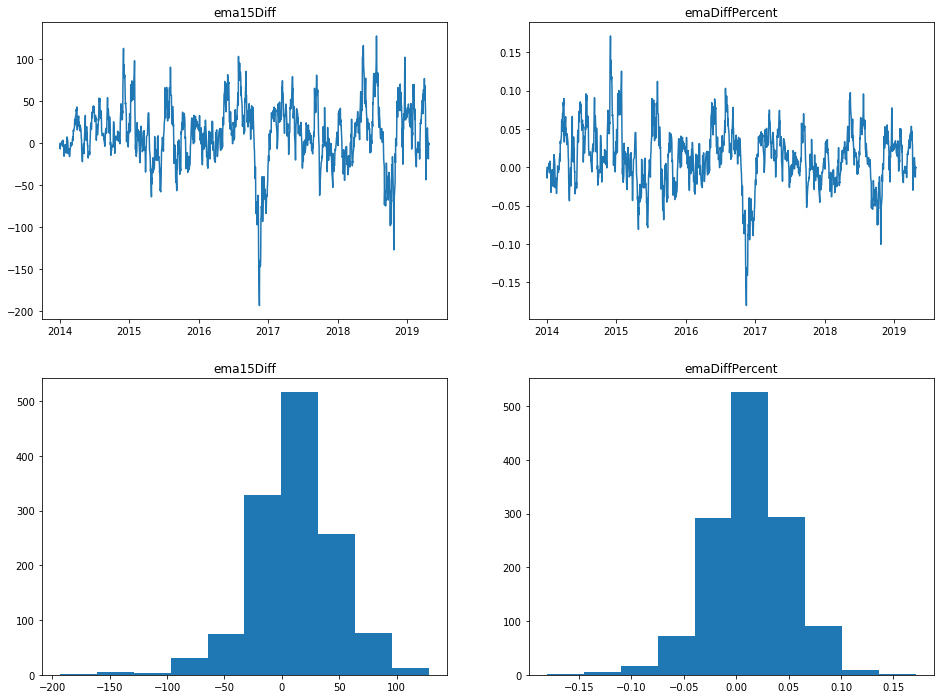

                   Close    Volume     ema15  ema15Diff  emaDiffPercent
Close           1.000000 -0.059953  0.991117   0.143248        0.025795
Volume         -0.059953  1.000000 -0.054889  -0.042311       -0.020766
ema15           0.991117 -0.054889  1.000000   0.010351       -0.103026
ema15Diff       0.143248 -0.042311  0.010351   1.000000        0.960611
emaDiffPercent  0.025795 -0.020766 -0.103026   0.960611        1.000000
                  Close     Volume        ema15  ema15Diff  emaDiffPercent
Date                                                                      
2019-04-22  1443.349976   737603.0  1450.670998  -7.321022       -0.005047
2019-04-23  1431.000000   601653.0  1449.441560 -18.441560       -0.012723
2019-04-24  1450.050049  1154712.0  1449.479591   0.570458        0.000394
2019-04-25  1447.949951  1161847.0  1449.383988  -1.434037       -0.000989
2019-04-26  1448.750000   704193.0  1449.344364  -0.594364       -0.000410


In [0]:
plt.rcParams["figure.figsize"] = (16,12)

a_stock["ema15"] = a_stock.ewm(15).mean()["Close"]
a_stock["ema15Diff"] = (a_stock["Close"]-a_stock["ema15"])
a_stock["emaDiffPercent"] = (a_stock["Close"]-a_stock["ema15"])/a_stock["ema15"]

fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(a_stock["ema15Diff"])
ax[0,0].set_title("ema15Diff")

ax[0,1].plot(a_stock["emaDiffPercent"])
ax[0,1].set_title("emaDiffPercent")

ax[1,0].hist(a_stock["ema15Diff"])
ax[1,0].set_title("ema15Diff")

ax[1,1].hist(a_stock["emaDiffPercent"])
ax[1,1].set_title("emaDiffPercent")

plt.show()
print(a_stock.corr())
print(a_stock.tail())


## Feature Scaling

Scaling data to fall in 0-1 range for better learning.

Ideally StandardScaller is a better fit for Time Series forecasting since the feature values could be a new high or new low. But for StandardScaller to give better results the data should be distributed normally. Since the stock prices variations are not normally distributed I am using StandardScaller here.

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


#Initilize scaler
#emaScaller = MinMaxScaler(feature_range = (0, 1))
#volumeScaller = MinMaxScaler(feature_range = (0, 1))

emaScaller = StandardScaler()
volumeScaller = StandardScaler()

emaScaller.fit(a_stock["emaDiffPercent"].reshape(-1,1))
volumeScaller.fit(a_stock.Volume.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]


StandardScaler(copy=True, with_mean=True, with_std=True)

## Split Training Data Set

In [0]:
training_set = a_stock[a_stock.index.year<VALIDATE_FROM_YEAR]

training_set_scalled = training_set.copy()
training_set_scalled["emaDiffPercent"] = emaScaller.transform(training_set.emaDiffPercent.values.reshape(-1,1))
training_set_scalled["Volume"] = volumeScaller.transform(training_set.Volume.values.reshape(-1,1))

print("TrainingSet Shape:",training_set_scalled.shape)
print("**Original Training Set:", training_set.tail(), sep="\n")
print("**Scalled Training Set:", training_set_scalled.tail(), sep="\n")

X_train = []
y_train = []
for i in range(HISTORY_LEN, len(training_set)-MAX_TRADING_DAYS):
    X_train.append(training_set_scalled[["emaDiffPercent","Volume"]][i-HISTORY_LEN:i].values)
    y_train.append(training_set_scalled["emaDiffPercent"][i:i+MAX_TRADING_DAYS].values.max())
X_train, y_train = np.array(X_train), np.array(y_train)


TrainingSet Shape: (984, 5)
**Original Training Set:
                  Close         Volume        ema15  ema15Diff  emaDiffPercent
Date                                                                          
2017-12-22  1129.935913  380476.127027  1126.570838   3.365075        0.002987
2017-12-26  1142.595581  826445.338497  1128.573931  14.021651        0.012424
2017-12-27  1140.907715  615620.374557  1130.115654  10.792061        0.009550
2017-12-28  1136.290527  540177.831570  1130.887513   5.403015        0.004778
2017-12-29  1150.290649  972741.027296  1133.312905  16.977745        0.014981
**Scalled Training Set:
                  Close    Volume        ema15  ema15Diff  emaDiffPercent
Date                                                                     
2017-12-22  1129.935913 -1.024957  1126.570838   3.365075       -0.120551
2017-12-26  1142.595581 -0.402784  1128.573931  14.021651        0.240152
2017-12-27  1140.907715 -0.696907  1130.115654  10.792061        0.130277


# LSTM Model


## Build LSTM Model

In [0]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

def createLstmModel(units, X_train):
    # Initialising the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = MAX_TRADING_DAYS, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = MAX_TRADING_DAYS))
    regressor.add(Dropout(0.2))

    # Adding a fifth Dense layer to predict MAX_TRADING_DAYS prices.
    regressor.add(Dense(units = MAX_TRADING_DAYS))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')#, metrics=["mse", "mape"])

    return regressor

Using TensorFlow backend.


## Train LSTM model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 180)           131760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 180)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 180)           259920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 180)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 15)            11760     
_________________________________________________________________
dropout_3 (Dropout)  

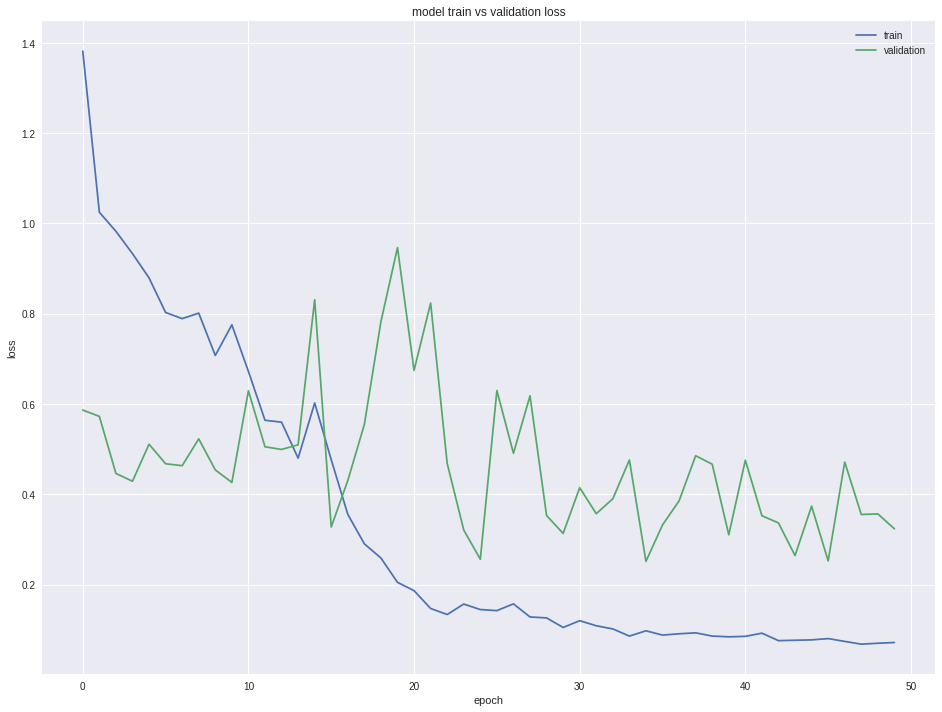

In [0]:
#os.remove(WEIGHT_FILE)

units = HISTORY_LEN*2
batch_size = 32
epochs = 50

lstmRegressor = createLstmModel(units, X_train)

lstmRegressor.summary()

if os.path.exists(WEIGHT_FILE):
    print(WEIGHT_FILE+" exists. Loading weights from file.")
    lstmRegressor.load_weights(WEIGHT_FILE)
    
checkpoint = ModelCheckpoint(WEIGHT_FILE, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Fitting the RNN to the Training set
history = lstmRegressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, shuffle=True, validation_split=0.1)#, callbacks=callbacks_list)
lstmRegressor.save_weights(WEIGHT_FILE)

# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


## Prediction

[[0.04299649]
 [0.0393319 ]
 [0.03676495]
 [0.03515684]
 [0.03453358]]


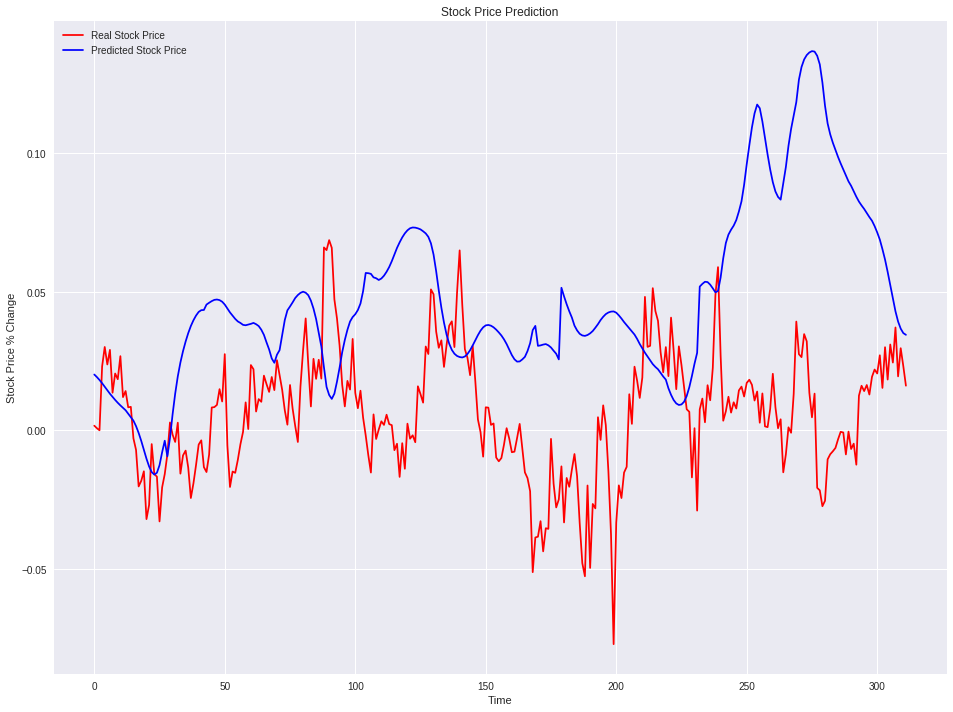

In [0]:
# Getting the predicted stock price of > VALIDATE_FROM_YEAR
dataset_total = a_stock
dataset_test = a_stock[a_stock.index.year>=VALIDATE_FROM_YEAR]

dataset_total_scalled = pd.DataFrame(dataset_total, columns = ['emaDiffPercent', 'Volume']) 
dataset_total_scalled["emaDiffPercent"] = emaScaller.transform(dataset_total.emaDiffPercent.values.reshape(-1,1))
dataset_total_scalled["Volume"] = volumeScaller.transform(dataset_total.Volume.values.reshape(-1,1))


X_test = []
for i in range(HISTORY_LEN,dataset_test.shape[0]+HISTORY_LEN):
    X_test.append(inputs[i-HISTORY_LEN:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

predicted_stock_price = emaScaller.inverse_transform(lstmRegressor.predict(X_test))
print(predicted_stock_price[-5:])

plt.plot(dataset_total[-predicted_stock_price.shape[0]:].emaDiffPercent.values, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price % Change')
plt.legend()
plt.show()

## Validate Efficiency

### Profit by Long Term Investment

In [0]:
data = a_stock[a_stock.index.year>=VALIDATE_FROM_YEAR]
old = data.iloc[0]["Close"]
new = data.iloc[-1]["Close"]
print("Price at start of %d: %.2f, Price Today: %.2f " %(VALIDATE_FROM_YEAR, old, new))
print("Profit %%: %.2f" % (((new-old)/old)*100))


Price at start of 2018: 1135.55, Price Today: 1507.50 
Profit %: 32.76


### Profit by LSTM

In [0]:
from tqdm import tqdm_notebook

UPPER_THRESHOLD = 0.04

y_pred = predicted_stock_price
y_test = a_stock[-predicted_stock_price.shape[0]:]
#print(y_pred.shape, y_test.shape)
#print(y_test.head())

position = "CLOSE"
nofDays = 0

buy = []
sell = []

for i in range(0,predicted_stock_price.shape[0]):
    today = y_test.Close[i]
    estimate = y_pred[i] 
    index = y_test.index[i]
    if position == "CLOSE":
        if estimate >= UPPER_THRESHOLD:
            #print (index, "BUY","Today:{}, Estimate:{}".format(today,estimate))
            position = "OPEN"
            nofDays = 1
            buy.append(index)
    else:
        nofDays += 1
        if nofDays >= MAX_TRADING_DAYS:
            #print (index, "SELL", "MAX_DAYS", "Today:{}".format(today))
            nofDays = 0
            position = "CLOSE"
            sell.append(index)
        if estimate <= LOWER_THRESHOLD:
            #print (index, "SELL")
            nofDays = 0
            position = "CLOSE"
            sell.append(index)
print("Buy=",len(buy), "Sell=",len(sell))

def cumulativeProfit(data, buy, sell):
    total_pp = 0
    #for index, row in signal.iterrows():
    for i in range(0, len(buy)):    
        profit = data.loc[sell[i]].Close - data.loc[buy[i]].Close
        profit_percent = profit/data.loc[buy[i]].Close
        print("Buy on: {:%Y-%m-%d}, Sell on:{:%Y-%m-%d}, Profit Rs: {:.2f}, Profit%: {:.2f}".format(buy[i], sell[i], profit, profit_percent*100))
        total_pp += profit_percent
    return total_pp


if len(buy) > len(sell):
    buy.pop()

p = cumulativeProfit(a_stock, buy, sell)
print("Profit %:", p*100)

Buy= 14 Sell= 13
Buy on: 2018-02-27, Sell on:2018-03-20, Profit Rs: -3.82, Profit%: -0.35
Buy on: 2018-03-21, Sell on:2018-04-12, Profit Rs: 61.21, Profit%: 5.59
Buy on: 2018-04-20, Sell on:2018-05-11, Profit Rs: 126.20, Profit%: 10.96
Buy on: 2018-05-28, Sell on:2018-06-15, Profit Rs: -33.35, Profit%: -2.54
Buy on: 2018-06-18, Sell on:2018-07-06, Profit Rs: 41.00, Profit%: 3.21
Buy on: 2018-07-09, Sell on:2018-07-27, Profit Rs: 71.58, Profit%: 5.26
Buy on: 2018-09-21, Sell on:2018-10-12, Profit Rs: -43.45, Profit%: -3.34
Buy on: 2018-10-16, Sell on:2018-11-06, Profit Rs: -26.06, Profit%: -2.06
Buy on: 2018-12-11, Sell on:2019-01-01, Profit Rs: 47.95, Profit%: 3.62
Buy on: 2019-01-02, Sell on:2019-01-22, Profit Rs: 23.65, Profit%: 1.71
Buy on: 2019-01-23, Sell on:2019-02-12, Profit Rs: 55.55, Profit%: 3.98
Buy on: 2019-02-14, Sell on:2019-03-07, Profit Rs: -3.75, Profit%: -0.27
Buy on: 2019-03-08, Sell on:2019-04-01, Profit Rs: 110.40, Profit%: 7.99
Profit %: 33.76055217245997
